In [20]:
from pytorch_tabnet.tab_model import TabNetClassifier
import itertools
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
df = pd.read_csv("../Datasets/new_df_with_colors.csv")
df_test = pd.read_csv("../Datasets/new_df_with_colors_val.csv")

In [22]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X_test = df_test.iloc[:, 0:-1]
y_test = df_test.iloc[:, -1]


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y,test_size=0.25)

In [38]:
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [25]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

c:\Users\Krystian\miniconda3\envs\pytorch_3_11\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [28]:
max_epochs = 100

In [29]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
) 

epoch 0  | loss: 4.06483 | train_accuracy: 0.15041 | valid_accuracy: 0.15084 |  0:00:01s
epoch 1  | loss: 2.94178 | train_accuracy: 0.15436 | valid_accuracy: 0.15306 |  0:00:02s
epoch 2  | loss: 2.67667 | train_accuracy: 0.16779 | valid_accuracy: 0.16395 |  0:00:03s
epoch 3  | loss: 2.61169 | train_accuracy: 0.13857 | valid_accuracy: 0.13116 |  0:00:05s
epoch 4  | loss: 2.37062 | train_accuracy: 0.14445 | valid_accuracy: 0.14576 |  0:00:06s
epoch 5  | loss: 2.10172 | train_accuracy: 0.19533 | valid_accuracy: 0.19145 |  0:00:07s
epoch 6  | loss: 2.04469 | train_accuracy: 0.17844 | valid_accuracy: 0.17252 |  0:00:08s
epoch 7  | loss: 1.91396 | train_accuracy: 0.22498 | valid_accuracy: 0.22795 |  0:00:09s
epoch 8  | loss: 1.89732 | train_accuracy: 0.18006 | valid_accuracy: 0.1849  |  0:00:11s
epoch 9  | loss: 1.796   | train_accuracy: 0.14558 | valid_accuracy: 0.14259 |  0:00:12s
epoch 10 | loss: 1.74765 | train_accuracy: 0.1783  | valid_accuracy: 0.18024 |  0:00:13s
epoch 11 | loss: 1.66

c:\Users\Krystian\miniconda3\envs\pytorch_3_11\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


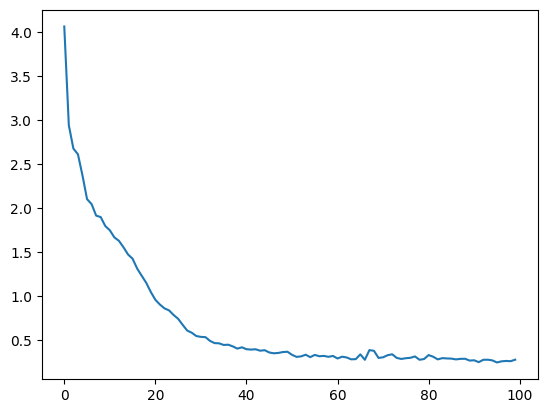

In [30]:
plt.plot(clf.history['loss'])

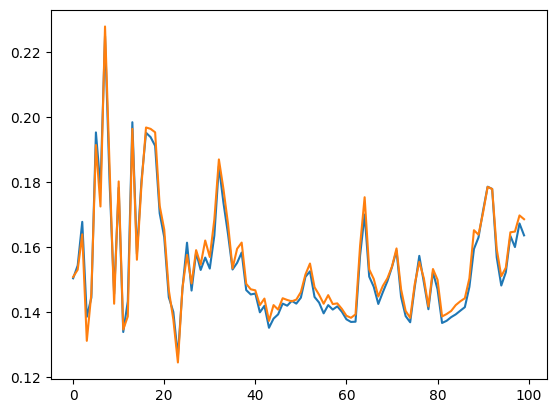

In [31]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [39]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE  : {clf.best_cost}")
print(f"FINAL TEST SCORE  : {test_acc}")

BEST VALID SCORE  : 0.22794584302940554
FINAL TEST SCORE  : 0.08522212148685404


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

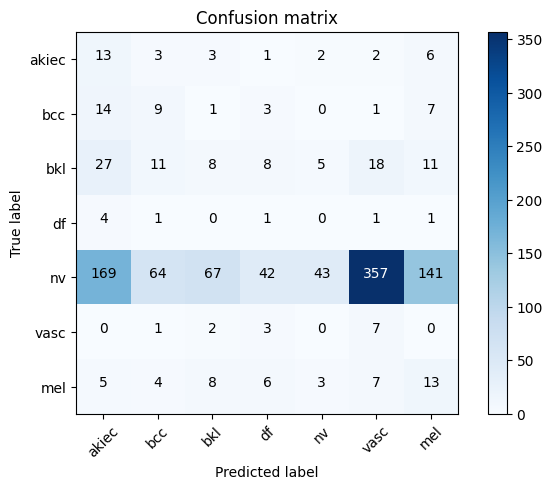

In [43]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [44]:
clf.feature_importances_


array([7.56984077e-03, 1.55551491e-02, 5.57712409e-02, 5.86714390e-03,
       2.74106656e-03, 4.03476258e-02, 1.60615628e-03, 8.27845116e-04,
       2.68742957e-02, 3.25932494e-03, 3.45925366e-03, 1.09090872e-03,
       5.12644943e-02, 3.32323238e-03, 2.78258763e-02, 5.23003804e-03,
       4.00467870e-05, 3.69984502e-03, 7.71684079e-02, 1.14510881e-02,
       5.17101810e-03, 5.53898431e-03, 4.45370797e-02, 3.14971321e-03,
       6.83555521e-04, 1.84230107e-06, 2.00182289e-03, 4.87485351e-04,
       3.24975880e-03, 4.83799403e-03, 4.04751965e-03, 1.70863774e-03,
       4.62031466e-03, 1.24657368e-03, 5.25347369e-04, 5.79226287e-03,
       3.11385329e-04, 5.69462315e-03, 1.13955982e-02, 4.04760239e-04,
       3.67821532e-03, 6.00202880e-03, 2.28447050e-03, 8.13456237e-05,
       6.83175189e-03, 9.97723937e-04, 6.79559811e-04, 4.78053002e-03,
       1.90028956e-04, 2.64530954e-02, 2.97396280e-02, 2.09388363e-02,
       1.22889952e-02, 1.00559543e-03, 3.00367504e-03, 1.89281916e-02,
      

In [ ]:
explain_matrix, masks = clf.explain(X_val)